In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import datetime
import torch
import json
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans
import os
from sklearn.preprocessing import OneHotEncoder
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
folder_path = '/path/to/folder'
files = []
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        files.append(file_path)

In [ ]:
folder_path = '/path/to/folder'
files = []
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        files.append(file_path)
map_cell_coordinates = {}
column_names = ['EVENT_ID', 'EVENT_RESULT', 'DURATION', 'REQUEST_RETRIES',
                    'SUB_TYPE', 'MSISDN', 'IMSI','MTMSI','IMEISV','MMEGI','MMEC',
                    'TAC','ECI','SGW','SGSN','L_CAUSE_PROT_TYPE','CAUSE_CODE',
                    'SUB_CAUSE_CODE','APN','PDN_DEFA ULT_BEARER_ID','PDN_PAA',
                    'PDN_PGW','ORIGINATING_CAUSE_PROT_TYPE','ORIGINATING_CAUSE_CODE',
                    'CSG_ID','OLD_MTMSI','OLD_TAC','OLD_MMEGI','OLD_MMEC','OLD_ECI',
                    'OLD_SGW','OLD_SGSN','MSC','TARGET_LAC','LAC','RAC','CI',
                    'HANDOVER_NODE_ROLE','HANDOVER_RAT_CHANGE_TYPE','HANDOVER_SGW_CHANGE_TYPE',
                    'TARGET_RNC_ID','TARGET_MACRO_ENODEB_ID','SRVCC_TYPE',
                    'CS_FALLBACK_SERVICE_TYPE','CSFB_TRIGGERED','L_SERVICE_REQ_TRIGGER','COMBINED_TAU_TYPE',
                    'DETACH_TRIGGER','EVENT_TIME','PAGING_ATTEMPTS','UE_REQUESTED_APN','DATE_HOUR']
list_imsi_remove = []
df_gNB_time = pd.DataFrame()
for file in files:
    batch_data = pd.read_csv(file, names=column_names, sep=";", header=None)
    data = data[['EVENT_ID', 'EVENT_RESULT', 'IMSI', 'ECI']]
    data = data.loc[data["EVENT_ID"].isin(["l_tau", "l_service_request", "l_handover"])]
    data = data.loc[data["EVENT_RESULT"]=="success"]
    imsi_removev = data[data['ECI'].isnull()]['IMSI'].tolist()
    list_imsi_remove.extend(imsi_removev)
    data = data.loc[data["ECI"].notna()]
    data = data[~data['ECI'].isin(list_imsi_remove)]
    # create temp dataframe
    dataframe = data[['IMSI']]
    dataframe['EVENT_TIME'] = data[['EVENT_TIME']]//1000
    dataframe['gNBID'] = data[['ECI']]//256
    dataframe_filter = dataframe.sort_values(by="EVENT_TIME")
    dataframe_filter, imsi_remove = remove_imsi(dataframe_filter)
    temp_dt = {row['IMSI']: [row['gNBID']] for idx, row in dataframe_filter.iterrows()}
    temp_df = pd.DataFrame(temp_dt)
    temp_df['timestamp'] = file.split('/')[-1].split('-')[0][1:-4]
    df_gNB_time = pd.concat([df_gNB_time, temp_df], axis=0)
    list_imsi_remove.extend(imsi_remove)
df_gNB_time = df_gNB_time.fillna(method='bfill')
df_gNB_time = df_gNB_time.fillna(method='ffill')
unique_counts = df_gNB_time.apply(lambda x: len(x.unique()))
columns_to_drop = unique_counts[unique_counts < 3].index
df_gNB_time_v2 = df_gNB_time.drop(columns_to_drop, axis=1)
df_gNB_time_v3 = df_gNB_time_v2.set_index('timestamp')
def remove_imsi(df):
    df = df.iloc[::-1]
    df = df.drop_duplicates(subset=['IMSI', 'gNBID'], keep='first')
    value_counts = df.groupby('IMSI')['gNBID'].nunique()
    groups_to_remove = value_counts[value_counts > 2].index
    filtered_df = df[~df['IMSI'].isin(groups_to_remove)]
    filtered_df = filtered_df.drop_duplicates(subset=['IMSI'])
    filtered_df = filtered_df.iloc[::-1]
    return filtered_df, groups_to_remove.to_list()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x86 in position 14: invalid start byte

## Clustering

### 1. cell to one hot vector

In [ ]:
merged_list = df_gNB_time_v3.values.flatten().tolist()
encoder = OneHotEncoder(sparse=False)
encoder.fit(np.array(merged_list).reshape(-1, 1))
df_gNB_time_v4 = pd.DataFrame()
for col in df_gNB_time_v3.columns:
    column_to_encode = df_gNB_time_v3[col].values.reshape(-1, 1)
    encoded_column = encoder.transform(column_to_encode).reshape(-1)
    df_gNB_time_v4[col] = encoded_column
df_gNB_time_v4_transposed = df_gNB_time_v4.transpose()
kmeans = KMeans(n_clusters=20, random_state=0, n_init="auto").fit(df_gNB_time_v4_transposed)
df_gNB_time_v4_transposed["cluser_id"] = kmeans.labels_
cluster_dict = df_gNB_time_v4_transposed["cluser_id"].to_dict()

### 2. cell to movement

In [ ]:
map_cell_coordinates = {}
df_long = pd.DataFrame()
df_lat = pd.DataFrame()

def cal_movement(cell_id1, cell_id2):
    return map_cell_coordinates[cell_id2][0] - map_cell_coordinates[cell_id1][0], map_cell_coordinates[cell_id2][1] - map_cell_coordinates[cell_id1][1]

for i in range(df_gNB_time_v3.shape[0] - 1):
    for col in df_gNB_time_v3.columns:
        df_long.iloc[ind][col], df_lat.iloc[ind][col] = cal_movement(df_gNB_time_v3.iloc[i][col], df_gNB_time_v3.iloc[i+1][col])
df_move = pd.concat([df1, df2], , ignore_index=True)
df_move_transposed = df_move.transpose()
kmeans = KMeans(n_clusters=20, random_state=0, n_init="auto").fit(df_move_transposed)
df_move["cluster_id"] = kmeans.labels_
cluster_move_dict = df_move["cluser_id"].to_dict()

## Predict location

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1. Onehot vector

In [ ]:
class DataloaderOneHot(object):
    def __init__(self, data, encoder, dict_cluster, device, seq_length = 16, batch_size = 16):
        self.data = pd.DataFrame(data)
        self.encoder = encoder
        self.dict_cluster = dict_cluster
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.flag = True
        self.index_start = 0
        self.device = device

    def get_item(self):
        out_put = []
        out_label = []
        for col in self.data.columns:
            column_to_encode = self.data[col].values.reshape(-1, 1)
            encoded_column = self.encoder.transform(column_to_encode).toarray()
            cluster = np.full((encoded_column.shape[0], 1), self.dict_cluster[col]).reshape(-1, 1)
            encoded_column = np.hstack((encoded_column, cluster))
            for index in range(self.batch_size):
                out_put.append(encoded_column[self.index_start + index: self.seq_length + self.index_start + index])
                out_label.append(encoded_column[self.seq_length + self.index_start + index,:-1])
        self.index_start = self.index_start + self.batch_size
        if (self.index_start + self.seq_length - 1 + self.batch_size >= self.data.shape[0]):
            self.flag = False
        return torch.Tensor(np.array(out_put[:])).to(self.device), torch.Tensor(np.array(out_label)).to(self.device)
class  SequenceLearningOnehot(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length, batch_size, num_cells, encoder, cluster_dict):
        super(SequenceLearningOnehot, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.num_cells = num_cells
        self.encoder = encoder
        self.cluster_dict = cluster_dict
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_cells)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, data, device):
        h_0 = Variable(torch.zeros(
            self.num_layers, data.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(
            self.num_layers, data.size(0), self.hidden_size)).to(device)
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(data, (h_0, c_0))
        h_out = h_out[-1, :, :]
        out = self.fc(h_out)
        out = self.softmax(out)
        return out

    def train(self, data, epochs, learning_rate, device):
        losses = []
        optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate, weight_decay = 1e-8)
        loss_function = torch.nn.MSELoss()
        for epoch in range(epochs):
#             print('Current timestamp: ', datetime.datetime.now(), ", ", epoch, " epoch")
            dataloader = DataloaderOneHot(data, encoder=self.encoder, dict_cluster=self.cluster_dict,
                                          seq_length=self.seq_length, batch_size=self.batch_size, device=device)
            while(dataloader.flag == True):
                data_window, data_label = dataloader.get_item()
                predict = self.forward(data_window, device)
                loss = loss_function(predict, data_label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
        return losses
    def test(self, data, device):
        losses = []
        dataloader = DataloaderOneHot(data, encoder=self.encoder, dict_cluster=self.cluster_dict,
                                seq_length = self.seq_length, batch_size = self.batch_size, device=device)
        while(dataloader.flag == True):
            data_window, data_label = dataloader.get_item()
            loss = torch.mul(self.forward(data_window, device), data_label)
            sum_lost = torch.sum(loss, dim=1).float()
            col_means = torch.mean(sum_lost, dim=0)
            losses.append(col_means.item())
        return np.mean(losses)
with open('/kaggle/input/gnbcluster/cluster_dict.json', 'r') as file:
    cluster_dict = json.load(file)
with open("/kaggle/input/gnbcluster/OneHotEncoder.pkl", 'rb') as file:
    encoder = pickle.load(file)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SequenceLearningOnehot(input_size=len(encoder.categories_[0])+1, hidden_size=2000, num_layers=3,
                               seq_length=16, batch_size=4, num_cells=len(encoder.categories_[0]),
                              encoder=encoder, cluster_dict=cluster_dict).to(device)
df_gNB_time_v3 = pd.read_csv("/kaggle/input/gnbcluster/df_gNB_time_v3.csv", index_col="timestamp")
num_ues = df_gNB_time_v3.shape[1]
step = int(0.01 * num_ues)
score = 0
for i in range(2):
    print(i)
    loss = model.train(data=df_gNB_time_v3.iloc[:, step*i:step*(i+1)], epochs=200, learning_rate=0.001, device=device)
    import matplotlib.pyplot as plt
    print(len(loss))
    plt.plot(loss, label='loss')
    plt.show()
# torch.save(model, 'model_v1.pth')
# torch.save(model, 'model_state_dict_v1.pth')
# incompatible_keys  = model.load_state_dict(torch.load('/kaggle/input/gnbcluster/model_state_dict.pth'), strict=True)
# print('Missing keys:', incompatible_keys.missing_keys)
# print('Unexpected keys:', incompatible_keys.unexpected_keys)
# model.eval()
for i in range(2):
    print('Current timestamp: ', datetime.datetime.now())
    score = score + model.test(data=df_gNB_time_v3.iloc[:, step*i:step*(i+1)], device=device)
print(score/1)

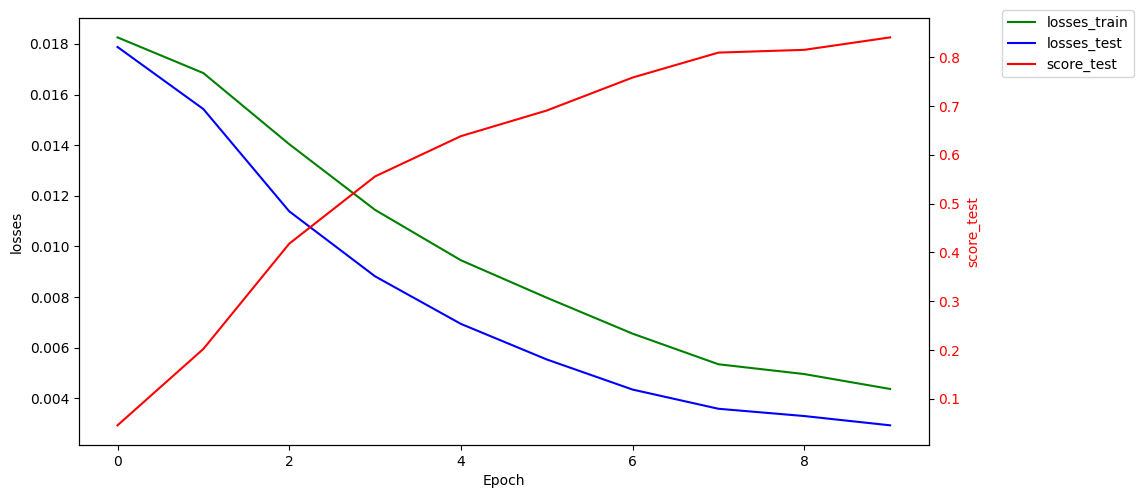

[0.04582743863151832, 0.20227982340888542, 0.4178779721260071, 0.5556472722779621, 0.6381648237054999, 0.6906477605754678, 0.7581852295181968, 0.8092983947558836, 0.8149474710226059, 0.8404483564875342]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import datetime
import torch
import json
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans
import os
from sklearn.preprocessing import OneHotEncoder
import pickle
class DataloaderOneHot(object):
    def __init__(self, data, encoder, dict_cluster, device, seq_length = 16, batch_size = 16):
        self.data = pd.DataFrame(data)
        self.encoder = encoder
        self.dict_cluster = dict_cluster
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.flag = True
        self.index_start = 0
        self.device = device

    def get_item(self):
        out_put = []
        out_label = []
        for col in self.data.columns:
            column_to_encode = self.data[col].values.reshape(-1, 1)
            encoded_column = self.encoder.transform(column_to_encode)#.toarray()
#             cluster = np.full((encoded_column.shape[0], 1), self.dict_cluster[col]/19).reshape(-1, 1)
#             encoded_column = np.hstack((encoded_column, cluster))
            for index in range(self.batch_size):
                out_put.append(encoded_column[self.index_start + index: self.seq_length + self.index_start + index])
                out_label.append(encoded_column[self.seq_length + self.index_start + index,:])
        self.index_start = self.index_start + self.batch_size
        if (self.index_start + self.seq_length - 1 + self.batch_size >= self.data.shape[0]):
            self.flag = False
        return torch.Tensor(np.array(out_put[:])).to(self.device), torch.Tensor(np.array(out_label)).to(self.device)
class  SequenceLearningOnehot(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length, batch_size, num_cells, encoder, cluster_dict):
        super(SequenceLearningOnehot, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.num_cells = num_cells
        self.encoder = encoder
        self.cluster_dict = cluster_dict
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_cells)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, data, device):
        h_0 = Variable(torch.zeros(
            self.num_layers, data.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(
            self.num_layers, data.size(0), self.hidden_size)).to(device)
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(data, (h_0, c_0))
        h_out = h_out[-1, :, :]
        out = self.fc(h_out)
        out = self.softmax(out)
        return out

    def train(self, data, datatest, epochs, learning_rate, device):
        losses_train = []
        losses_test = []
        score_test = []
        optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate, weight_decay = 1e-8)
        loss_function = torch.nn.MSELoss()
        for epoch in range(epochs):
#             print('Current timestamp: ', datetime.datetime.now(), ", ", epoch, " epoch")
            dataloader = DataloaderOneHot(data, encoder=self.encoder, dict_cluster=self.cluster_dict,
                                          seq_length=self.seq_length, batch_size=self.batch_size, device=device)
            losses = []
            while(dataloader.flag == True):
                data_window, data_label = dataloader.get_item()
                predict = self.forward(data_window, device)
                loss = loss_function(predict, data_label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            losses_train.append(sum(losses) / len(losses))
            loss_test, score = self.test(datatest, device)
            losses_test.append(loss_test)
            score_test.append(score)
        return losses_train, losses_test, score_test
    def test(self, data, device):
        score_test = []
        losses_test = []
        loss_function = torch.nn.MSELoss()
        dataloader = DataloaderOneHot(data, encoder=self.encoder, dict_cluster=self.cluster_dict,
                                seq_length = self.seq_length, batch_size = self.batch_size, device=device)
        while(dataloader.flag == True):
            data_window, data_label = dataloader.get_item()
            predict = self.forward(data_window, device)
            score = torch.mul(predict, data_label)
            loss_test = loss_function(predict, data_label)
            sum_lost = torch.sum(score, dim=1).float()
            col_means = torch.mean(sum_lost, dim=0)
            score_test.append(col_means.item())
            losses_test.append(loss_test.item())
        return np.mean(losses_test), np.mean(score_test)
# with open('/kaggle/input/gnbcluster/cluster_dict.json', 'r') as file:
#     cluster_dict = json.load(file)
# with open("/kaggle/input/gnbcluster/OneHotEncoder.pkl", 'rb') as file:
#     encoder = pickle.load(file)
df_gNB_time = pd.read_csv("/kaggle/input/gnbcluster/df_gNB_time_v95 (1).csv", index_col="timestamp")

merged_list = df_gNB_time.values.flatten().tolist()
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(np.array(merged_list).reshape(-1,1))
df_gNB_time_v4 = pd.DataFrame(columns=df_gNB_time.columns)
for col in df_gNB_time.columns:
    column_to_encode = df_gNB_time[col].values.reshape(-1, 1)
    encoded_column = encoder.transform(column_to_encode).reshape(-1)
    df_gNB_time_v4[col] = encoded_column
df_gNB_time_v4_transposed = df_gNB_time.transpose()
kmeans = KMeans(n_clusters=20, random_state=0, n_init="auto").fit(df_gNB_time_v4_transposed)
df_gNB_time_v4_transposed["cluser_id"] = kmeans.labels_
cluster_dict = df_gNB_time_v4_transposed["cluser_id"].to_dict()
path_file = "cluster_dict_v95(1).json"
with open(path_file, 'w') as file:
    json.dump(cluster_dict, file, indent=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SequenceLearningOnehot(input_size=len(encoder.categories_[0]), hidden_size=2000, num_layers=3,
                               seq_length=16, batch_size=1, num_cells=len(encoder.categories_[0]),
                               encoder=encoder, cluster_dict=cluster_dict).to(device)
num_ues = df_gNB_time.shape[1]
step = int(0.3 * num_ues)
losses_train, losses_test, score_test = model.train(data=df_gNB_time.iloc[:, 0:step],
                                                    datatest=df_gNB_time.iloc[:, step:step*2],
                                                    epochs=10, learning_rate=0.0001, device=device)

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(losses_train, 'g-', label='losses_train')
ax1.plot(losses_test, 'b-', label='losses_test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('losses')

ax2 = ax1.twinx()
ax2.plot(score_test, 'r-', label='score_test')
ax2.set_ylabel('score_test', color='r')
ax2.tick_params(axis='y', labelcolor='r')
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('')
fig.tight_layout()
plt.show()
print(score_test)

# df_gNB_time_v3 = pd.read_csv("/kaggle/input/gnbcluster/df_gNB_time_v3.csv", index_col="timestamp")
# num_ues = df_gNB_time_v3.shape[1]
# step = int(0.04 * num_ues)
# score = 0
# for i in range(1):
#     print(i)
#     losses_train, losses_test, score_test = model.train(data=df_gNB_time_v3.iloc[:, step*i:step*(i+1)],
#                                                         datatest=df_gNB_time_v3.iloc[:, step*(i+1):step*(i+2)],
#                                                         epochs=150, learning_rate=0.001, device=device)
#     import matplotlib.pyplot as plt
#     fig, ax1 = plt.subplots(figsize=(10, 5))

#     ax1.plot(losses_train, 'g-', label='losses_train')
#     ax1.plot(losses_test, 'b-', label='losses_test')
#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('losses')

#     ax2 = ax1.twinx()
#     ax2.plot(score_test, 'r-', label='score_test')
#     ax2.set_ylabel('score_test', color='r')
#     ax2.tick_params(axis='y', labelcolor='r')
#     fig.legend(loc='upper left', bbox_to_anchor=(1, 1))
#     plt.title('')
#     fig.tight_layout()
#     plt.show()



# torch.save(model, 'model_v1.pth')
# torch.save(model, 'model_state_dict_v1.pth')for i in range(2):
#     print('Current timestamp: ', datetime.datetime.now())
#     score = score + model.test(data=df_gNB_time_v3.iloc[:, step*i:step*(i+1)], device=device)
# print(score/1)

### 2. Movement

In [ ]:
class DataloaderMove(object):
    def __init__(self, data_lat, data_long, dict_cluster, seq_length = 16, batch_size = 16):
        self.data_lat = pd.DataFrame(data_lat)
        self.data_long = pd.DataFrame(data_long)
        self.dict_cluster = dict_cluster
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.flag = True
        self.index_start = 0

    def get_item(self):
        out_put = []
        out_label = []
        for col in self.data_lat.columns:
            data_move = pd.DataFrame()
            data_move["lat"] = self.data_lat[col]
            data_move["long"] = self.data_long[col]
            data_move["cluser_id"] = self.self.dict_cluster[col]/19
            for index in range(self.batch_size):
                out_put.append(data_move[self.index_start + index: self.seq_length + self.index_start + index])
                out_label.append(data_move.iloc[self.seq_length + self.index_start + index:self.seq_length + self.index_start + index + 1,:-1])
        self.index_start = self.index_start + self.batch_size
        if (self.index_start + self.seq_length - 1 + self.batch_size >= self.data_lat.shape[0]):
            self.flag = False
        return torch.Tensor(np.array(out_put[:])), torch.Tensor(np.array(out_label))

In [ ]:
class  SequenceLearningMove(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, seq_length, batch_size, num_classes = 1):
        super(SequenceLearningMove, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

    def train(self, data, epochs, learning_rate):
        losses = []
        optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate, weight_decay = 1e-8)
        loss_function = torch.nn.MSELoss()
        for epoch in range(epochs):
            print('Current timestamp: ', datetime.datetime.now(), ", ", epoch, " epoch")
            dataloader = DataloaderMove(data, seq_length = self.seq_length,batch_size= self.batch_size)
            while(dataloader.flag == True):
                data_window, data_label = dataloader.get_item()
                predict = self.forward(data_window)
                loss = loss_function(predict, data_label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
        return losses
    def test(self, test):
        losses = []
        for i in range(self.seq_length):
            losses.append(0)
        loss_function = torch.nn.MSELoss()
        dataloader = Dataloader(test, seq_length = self.seq_length, batch_size = self.batch_size)
        while(dataloader.flag == True):
            data_window, data_label = dataloader.get_item()
            loss = loss_function(self.forward(data_window), data_label)
            losses.append(loss.detach().numpy())
        threshold = np.mean(losses) + scale * np.std(losses)
        label = []
        for i in range(len(losses)):
            if losses[i] > threshold:
                label.append(1)
            else:
                label.append(0)
        return losses, label

In [ ]:
import pickle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with open('/kaggle/input/gnbcluster/cluster_dict.json', 'r') as file:
    cluster_dict = json.load(file)
with open("/kaggle/input/gnbcluster/OneHotEncoder.pkl", 'rb') as file:
    encoder = pickle.load(file)
model = SequenceLearningOnehot(input_size=len(encoder.categories_[0])+1, hidden_size=2000, num_layers=3,
                               seq_length=15, batch_size=16, num_cells=len(encoder.categories_[0]),
                              encoder=encoder, cluster_dict=cluster_dict).to(device)
df_gNB_time_v3 = pd.read_csv("/kaggle/input/gnbcluster/df_gNB_time_v3.csv", index_col="timestamp")
num_ues = df_gNB_time_v3.shape[1]
data_train = pd.DataFrame()
data_test = pd.DataFrame()
thresh = 0.8 * num_ues
columns = df_gNB_time_v3.columns
for ind in range(num_ues):
    if ind < thresh:
        data_train[columns[ind]] = df_gNB_time_v3[columns[ind]]
    else:
        data_test[columns[ind]] = df_gNB_time_v3[columns[ind]]
model.train(data=data_train, epochs=20, learning_rate=0.001, device=device)
print(model.test(data_test))

In [ ]:
import hmmlearn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tạo dữ liệu giả định hình sin đa biến
np.random.seed(42)
t = np.linspace(0, 10, 100)  # 100 điểm dữ liệu từ 0 đến 10

# Biến thứ nhất là hình sin
data1 = np.sin(t) + 0.1 * np.random.randn(100)

# Biến thứ hai là hình cosin
data2 = np.cos(t) + 0.1 * np.random.randn(100)

# Ghép hai biến thành một ma trận đa biến
data = np.column_stack([data1, data2])

# Vẽ dữ liệu
plt.plot(t, data1, label='Biến 1 (sin)')
plt.plot(t, data2, label='Biến 2 (cos)')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.legend()
plt.show()
from hmmlearn.hmm import GaussianHMM

# Định nghĩa và huấn luyện mô hình HMM cho dữ liệu đa biến
n_components = 3  # Số lượng trạng thái ẩn
hmm_model = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000)
hmm_model.fit(data)

# Dự đoán trạng thái ẩn cho dữ liệu
hidden_states = hmm_model.predict(data)

# Vẽ dữ liệu và các trạng thái ẩn
plt.figure(figsize=(15, 8))
for i in range(n_components):
    state = (hidden_states == i)
    plt.plot(t[state], data1[state], 'o', label=f'State {i+1} (Biến 1)')
    plt.plot(t[state], data2[state], 'x', label=f'State {i+1} (Biến 2)')
plt.plot(t, data1, label='Biến 1 (sin)', alpha=0.5)
plt.plot(t, data2, label='Biến 2 (cos)', alpha=0.5)
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = pd.read_csv("vehicle_movement.csv")

coordinates = data[['latitude', 'longitude']].values
speed = data['speed'].values
direction = data['direction'].values

observations = np.column_stack([coordinates, speed, direction])
X_train, X_test = train_test_split(observations, test_size=0.2, random_state=42)

n_components = 3
hmm_model = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000)
hmm_model.fit(X_train)

def predict_next_direction(model, current_observation):
    hidden_state = model.predict(current_observation.reshape(1, -1))
    next_state_probabilities = model.transmat_[hidden_state]
    next_state = np.argmax(next_state_probabilities)
    return next_state

current_observation = observations[-1]
predicted_state = predict_next_direction(hmm_model, current_observation)

hidden_states_test = hmm_model.predict(X_test)

accuracy = accuracy_score(hidden_states_test, hmm_model.predict(X_test))
print(f"Độ chính xác của mô hình: {accuracy}")
